## Calculate F1 scores to optimize MCL clustering

This notebook generates the curve of F1 score vs the MCL inflation parameter. See Figure S4I. 

This notebook depends on the `complex_comparison.py` script from Drew et al., 2017. This script is copied in this repo in `scripts/external/`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../../scripts/external/')
import complex_comparison as cc

sys.path.append('../../scripts/interactome_markov_clustering')
%matplotlib inline

### Load the 'gold standard' reference
The complex comparison script by Drew et al., 2017 requires a list of gold standard complexes (i.e., clusters). Following Drew et al., we use CORUM complexes as our gold standard. We also use the Jaccard distance between complexes to combine complexes that have a high number of mutual members. This pre-computed list of CORUM complexes is saved as `'processed_human_corum.csv'`.

In [2]:
root = '../../data/ppi_analysis/clust_scoring/'
external_root = '../../data/external/'

corums = pd.read_csv(external_root + 'processed_human_corum.csv', index_col=0)
standard = corums.groupby('complex')['gene_names'].apply(list).to_list()

### Calculate the grand F1 scores
Here we calculate the grand F1 scores and standard deviations (because grand F1 score is computed on a sampling) for both clusters based on stoichiometric edges and those that have no edge weights. This is done for MCL inflation parameters from 1-7. 

In [ ]:
clust_means, clust_stds, no_clust_means, no_clust_stds = [],[],[],[]

# iterate through computed MCL inflation parameters
for ind in map(str, np.arange(1,8)):

    # update the iteration counter
    sys.stdout.write("\r{}".format(ind))

    # Open cluster files based on stoichiometric edges and no stoichiometry
    clust_name = 'stoich_clustering_mcl_i%s.0.csv' % ind
    no_clust_name = 'no_%s' % clust_name
    
    clust = pd.read_csv(root + clust_name)
    no_clust = pd.read_csv(root + no_clust_name)

    # save all clusters in a list
    clust_grouped = pd.DataFrame(clust.groupby('super_cluster')['gene_names'].apply(list))
    clusts = clust_grouped['gene_names'].to_list()

    # repeat for no-stoichiometry computed clusters
    no_clust_grouped = pd.DataFrame(no_clust.groupby('super_cluster')['gene_names'].apply(list))
    no_clusts = no_clust_grouped['gene_names'].to_list()

    # compute mean and stdev of grand f1 scores on 50 repetitions, and max_clique of 5
    clust_mean, clust_std = cc.repeat_cluster_scoring(standard, clusts, max_clique=5, n_repeat=10)
    no_clust_mean, no_clust_std = cc.repeat_cluster_scoring(
        standard, no_clusts, max_clique=5, n_repeat=10
    )

    clust_means.append(clust_mean)
    clust_stds.append(clust_std)
    no_clust_means.append(no_clust_mean)
    no_clust_stds.append(no_clust_std)

### Plot the F1 scores as a function of the inflation parameter

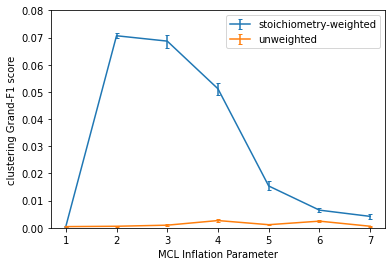

In [22]:
fig, ax =plt.subplots(figsize=(6,4))
x = np.arange(1,8)

ax.errorbar(x, clust_means, yerr=clust_stds, capsize=2, label='stoichiometry-weighted')
ax.errorbar(x, no_clust_means, yerr=no_clust_stds, capsize=2, label='unweighted')

ax.set_ylim(0,0.08)
ax.set_xlabel('MCL Inflation Parameter')
ax.set_ylabel('clustering Grand-F1 score')
plt.legend()